In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

In [13]:
data = pd.read_csv('/Volumes/GoogleDrive/My Drive/data/case_study_data/dataset_1.csv')
data['Date'] = data['Date'].ffill()

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             336 non-null    object
 1   time (local)     336 non-null    int64 
 2   eyeballs         336 non-null    int64 
 3   zeroes           336 non-null    int64 
 4   completed trips  336 non-null    int64 
 5   requests         336 non-null    int64 
 6   unique drivers   336 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 18.5+ KB


In [14]:
data.head()

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,10-Sep-12,8,6,0,2,2,14
2,10-Sep-12,9,8,3,0,0,14
3,10-Sep-12,10,9,2,0,1,14
4,10-Sep-12,11,11,1,4,4,11


In [44]:
data.columns = [ i.lower().rstrip() for i in data.columns]
data.columns

Index(['date', 'time (local)', 'eyeballs', 'zeroes', 'completed trips',
       'requests', 'unique drivers'],
      dtype='object')

###  Which date had the most completed trips during the two week period?


In [41]:
trips_by_date = data.groupby(['date'], as_index=False)['completed trips'].sum()
max_trips = trips_by_date.iloc[trips_by_date['completed trips'].idxmax()]['date']
print('The date with the most completed trips is: {}'.format(max_trips))

The date with the most completed trips is: 22-Sep-12


In [68]:
trips_by_date

,date,completed trips,rolling_avg
0,10-Sep-12,26,26.000000
1,11-Sep-12,40,33.000000
2,12-Sep-12,91,52.333333
3,13-Sep-12,45,58.666667
4,14-Sep-12,108,81.333333
5,15-Sep-12,199,117.333333
6,16-Sep-12,93,133.333333
7,17-Sep-12,57,116.333333
8,18-Sep-12,42,64.000000
9,19-Sep-12,41,46.666667


### What was the highest number of completed trips within a 24 hour period?

In [59]:
# to be able to use resample function, create timestamp and use as index
def create_timestamp(date, time):
    return pd.to_datetime(f"{date} {time}:00")
data['timestamp'] = data.apply(lambda row: create_timestamp(row['date'], row['time (local)']), axis=1)
data.sample(1)


,date,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,timestamp
245,20-Sep-12,12,16,2,3,3,12,2012-09-20 12:00:00


In [71]:
# calculate rollings sums with 24 hours period
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=24)
df_agg_twentyfour_hrs = data.set_index("timestamp").rolling(window=indexer, min_periods=1).sum()
df_agg_twentyfour_hrs.nlargest(1, 'completed trips')


,time (local),eyeballs,zeroes,completed trips,requests,unique drivers
timestamp,,,,,,
2012-09-21 17:00:00,276.0,1015.0,207.0,278.0,367.0,349.0


In [74]:
df_agg_twentyfour_hrs
time_format = '%Y-%m-%d %H:%M'
df_agg_twentyfour_hrs['Time Interval'] = df_agg_twentyfour_hrs.index.strftime(time_format) + '-' + (df_agg_twentyfour_hrs.index + pd.Timedelta('24 hours')).strftime(time_format)

In [75]:
df_agg_twentyfour_hrs.head(2)

,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,Time Interval
timestamp,,,,,,,
2012-09-10 07:00:00,276.0,212.0,38.0,29.0,39.0,150.0,2012-09-10 07:00-2012-09-11 07:00
2012-09-10 08:00:00,276.0,217.0,38.0,29.0,39.0,146.0,2012-09-10 08:00-2012-09-11 08:00


In [88]:
max_trips_in_24_hr_time_interval = df_agg_twentyfour_hrs[df_agg_twentyfour_hrs.index == df_agg_twentyfour_hrs['completed trips'].idxmax()]
max_trips_in_24_hr_time_interval['Time Interval'].values[0]
max_trips_in_24_hr_time_interval['completed trips'].values[0]

print('The time interval with the most completed trips is: {}'.format(max_trips_in_24_hr_time_interval['Time Interval'].values[0]))
print('The number of completed trips in that time interval is: {}'.format(max_trips_in_24_hr_time_interval['completed trips'].values[0]))

The time interval with the most completed trips is: 2012-09-21 17:00-2012-09-22 17:00
The number of completed trips in that time interval is: 278.0


### Which hour of the day had the most requests during the two week period?

In [94]:
trips_by_hour = data.groupby(['time (local)'], as_index=False)['requests'].sum()
max_trips = trips_by_hour.iloc[trips_by_hour['requests'].idxmax()]['time (local)']
print('The hour with the most requests trips is: {}'.format(max_trips))

The hour with the most requests trips is: 23


### What percentages of all zeroes during the two week period occurred on weekend (Friday at 5 pm to Sunday at 3 am)?

In [96]:
data['weekday'] = pd.to_datetime(data['date']).dt.day_name()
data.head(2)

,date,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,timestamp,weekday
0,10-Sep-12,7,5,0,2,2,9,2012-09-10 07:00:00,Monday
1,10-Sep-12,8,6,0,2,2,14,2012-09-10 08:00:00,Monday


In [97]:
weekend_filter = (data['weekday'] == 'Saturday')  | ((data['weekday'] == 'Sunday') & (data['time (local)'] <= 3)) | ((data['weekday'] == 'Friday') & (data['time (local)'] >= 17))
weekend_data = data[weekend_filter]

In [103]:
round(weekend_data['zeroes'].sum()/data['zeroes'].sum(),2)*100

45.0

### What is the weighted average ratio of completed trips per driver during the two week period?

In [107]:
data_without_zero_unique_drivers = data[data['unique drivers'] > 0]
ratio_of_avg_trips_completed = (data_without_zero_unique_drivers['completed trips']/data_without_zero_unique_drivers['unique drivers']).mean()
print('The ratio of average trips completed to average unique drivers is: {}'.format(ratio_of_avg_trips_completed))

The ratio of average trips completed to average unique drivers is: 0.4743397876937869


### In drafting a driver schedule in terms of 8 hours shifts, when are the busiest 8 consecutive hours over the two week period in terms of unique requests? A new shift starts in every 8 hours. Assume that a driver will work same shift each day.

In [111]:
data

,date,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,timestamp,weekday
0,10-Sep-12,7,5,0,2,2,9,2012-09-10 07:00:00,Monday
1,10-Sep-12,8,6,0,2,2,14,2012-09-10 08:00:00,Monday
2,10-Sep-12,9,8,3,0,0,14,2012-09-10 09:00:00,Monday
3,10-Sep-12,10,9,2,0,1,14,2012-09-10 10:00:00,Monday
4,10-Sep-12,11,11,1,4,4,11,2012-09-10 11:00:00,Monday
...,...,...,...,...,...,...,...,...,...
331,24-Sep-12,2,3,3,0,2,0,2012-09-24 02:00:00,Monday
332,24-Sep-12,3,3,3,0,1,0,2012-09-24 03:00:00,Monday
333,24-Sep-12,4,1,1,0,0,0,2012-09-24 04:00:00,Monday
334,24-Sep-12,5,4,2,1,1,3,2012-09-24 05:00:00,Monday


In [117]:
# resample with 8 hours period                               
df_agg_eight_hrs = data.set_index("timestamp").resample('8H').sum()
df_agg_eight_hrs.head()

,time (local),eyeballs,zeroes,completed trips,requests,unique drivers
timestamp,,,,,,
2012-09-10 00:00:00,7,5,0,2,2,9
2012-09-10 08:00:00,92,78,10,9,11,89
2012-09-10 16:00:00,156,106,16,15,21,40
2012-09-11 00:00:00,28,33,12,5,7,17
2012-09-11 08:00:00,92,108,11,5,6,58


In [120]:
time_format = '%Y-%m-%d %H:%M'
df_agg_eight_hrs['Time_Interval'] = df_agg_eight_hrs.index.strftime(time_format) + '-' + (df_agg_eight_hrs.index + pd.Timedelta('8 hours')).strftime(time_format)
df_agg_eight_hrs.nlargest(1, 'requests')


,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,Time_Interval
timestamp,,,,,,,
2012-09-21 16:00:00,156,515,88,153,192,198,2012-09-21 16:00-2012-09-22 00:00


### True or False: Driver supply always increases when demand increases during the two week period.


In [132]:
# create empty dataframe with only timestamps
difference_data = pd.DataFrame(data['timestamp'])
# calculate request differences to catch request increases
difference_data['request_diff'] = data['requests'].shift(-1) - data['requests']
# do same of supply side
difference_data['supply_diff'] = data['unique drivers'].shift(-1) - data['unique drivers']
difference_data

,timestamp,request_diff,supply_diff
0,2012-09-10 07:00:00,0.0,5.0
1,2012-09-10 08:00:00,-2.0,0.0
2,2012-09-10 09:00:00,1.0,0.0
3,2012-09-10 10:00:00,3.0,-3.0
4,2012-09-10 11:00:00,-2.0,0.0
...,...,...,...
331,2012-09-24 02:00:00,-1.0,0.0
332,2012-09-24 03:00:00,-1.0,0.0
333,2012-09-24 04:00:00,1.0,3.0
334,2012-09-24 05:00:00,1.0,4.0


In [134]:
# check if request increases, supply also increases 
(difference_data[difference_data['request_diff'] > 0]['supply_diff'] > 0).all().item()

False

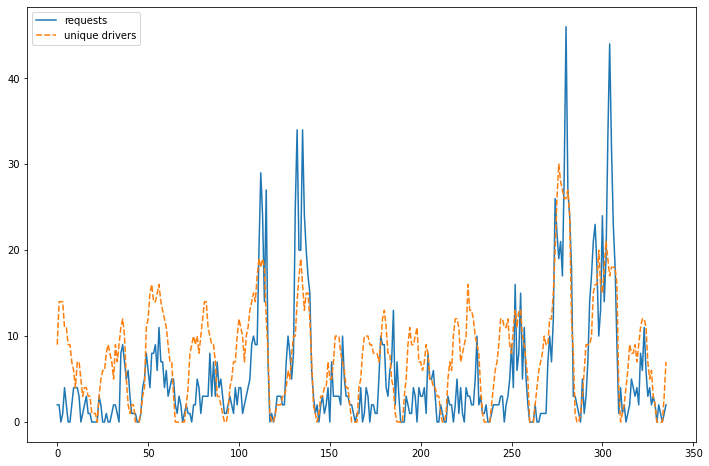

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.lineplot(data=data[['requests', 'unique drivers', 'timestamp']])
plt.show()

### In which 72 hour period is the ratio of Zeroes to Eyeballs the highest?

In [147]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=72)
df_agg_three_days = data.set_index("timestamp").rolling(window=indexer, min_periods=1).sum()
df_agg_three_days['zeros_to_eyeballs_ratio'] = df_agg_three_days['zeroes'] / df_agg_three_days['eyeballs']


In [148]:
time_format = "%Y/%m/%d %H:%M"
df_agg_three_days['Time Interval']  = df_agg_three_days.index.strftime(time_format) +  "-" + (df_agg_three_days.index + pd.Timedelta('3 days')).strftime(time_format)
df_agg_three_days

,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,prevRequest,zeros_to_eyeballs_ratio,Time Interval
timestamp,,,,,,,,,
2012-09-10 07:00:00,828.0,956.0,172.0,159.0,211.0,473.0,210.0,0.179916,2012/09/10 07:00-2012/09/13 07:00
2012-09-10 08:00:00,828.0,961.0,173.0,158.0,210.0,468.0,209.0,0.180021,2012/09/10 08:00-2012/09/13 08:00
2012-09-10 09:00:00,828.0,964.0,174.0,157.0,209.0,462.0,209.0,0.180498,2012/09/10 09:00-2012/09/13 09:00
2012-09-10 10:00:00,828.0,970.0,175.0,157.0,209.0,457.0,210.0,0.180412,2012/09/10 10:00-2012/09/13 10:00
2012-09-10 11:00:00,828.0,976.0,176.0,159.0,210.0,453.0,208.0,0.180328,2012/09/10 11:00-2012/09/13 11:00
...,...,...,...,...,...,...,...,...,...
2012-09-24 02:00:00,20.0,20.0,10.0,3.0,6.0,10.0,4.0,0.500000,2012/09/24 02:00-2012/09/27 02:00
2012-09-24 03:00:00,18.0,17.0,7.0,3.0,4.0,10.0,3.0,0.411765,2012/09/24 03:00-2012/09/27 03:00
2012-09-24 04:00:00,15.0,14.0,4.0,3.0,3.0,10.0,3.0,0.285714,2012/09/24 04:00-2012/09/27 04:00


In [149]:
df_agg_three_days.nlargest(1, 'zeros_to_eyeballs_ratio')

,time (local),eyeballs,zeroes,completed trips,requests,unique drivers,prevRequest,zeros_to_eyeballs_ratio,Time Interval
timestamp,,,,,,,,,
2012-09-24 01:00:00,21.0,27.0,17.0,3.0,6.0,10.0,6.0,0.62963,2012/09/24 01:00-2012/09/27 01:00


In [150]:
df_agg_three_days.nlargest(1, 'zeros_to_eyeballs_ratio')['Time Interval']

timestamp
2012-09-24 01:00:00    2012/09/24 01:00-2012/09/27 01:00
Name: Time Interval, dtype: object

### If we have to add 5 drivers to any single hour of every day during the two week period, which hour should you add them to?

In [152]:
# check time difference between the beginning and end
(data['timestamp'][data.shape[0]-1]-data['timestamp'][0])

Timedelta('13 days 23:00:00')

In [154]:
# compare it with timedelta 14 days to see if the difference exactly matches as 14 days
pd.Timedelta('14 days') == data['timestamp'][data.shape[0]-1]-data['timestamp'][0]

False

In [156]:
# the difference is less than 14 days
pd.Timedelta('14 days') > data['timestamp'][data.shape[0]-1]-data['timestamp'][0]


True